In [16]:
import torch
from torch.fft import fft, ifft
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [17]:
waveform, sr = torchaudio.load('input.wav')
waveform = waveform[0]
waveform

# normalized moving average filter
P = 11
h = torch.ones(P) / P

### overlap-add
[DFT LPF IDFT of a speech signal using overlap add and overlap save method]
- Read the input .wav file.
- The LPF is simply moving average filter, i.e., ℎ[𝑛]=1,0≤𝑛≤10 (𝑃=11)

1) For overlap add method,
- Frame shift is 80 samples. (𝐿=80)
- For every 80 samples, take 128 point FFT. (𝑁=128)
- Multiply it with the FFT of the filter.
- Compute 128 point IFFT and reconstruct the time domain signal.
- Plot of the magnitude spectrum for the 100th frame with that of the input signal before filtering for each method.
- Compare the outputs of the overlap add and overlap save methods.

In [18]:
L = 80  # frame shift
N = 128  # fft size
overlap = N - L  # overlap size
# h_padded = torch.zeros(N) 
# h_padded[:len(h)] = h

# initialize output signal
output_length1 = waveform.size(0) + overlap
output_signal1 = torch.zeros(output_length1)


for i in range(0, waveform.size(0), L):
    frame = waveform[i:i+L]
    # print(i, frame.size(0))
    # 18800 + 59
    # Zero pad the frame if it is s shorter than N (last frame)
    # if frame.size(0) < N:
    #     frame = torch.nn.functional.pad(frame, (0, N - frame.size(0)), mode='constant', value=0)

    frame_fft = fft(frame, N)
    h_fft = fft(h, N)
    filtered_frame_fft = frame_fft * h_fft
    if i == 99*80:
        before_filtering1 = frame_fft
        after_filtering1 = filtered_frame_fft
    filtered_frame = ifft(filtered_frame_fft)

    # Determine the length of the filtered frame to be added to the output signal
    frame_length = min(N, output_signal1.size(0) - i)
    
    # Overlap-add to reconstruct the output signal
    output_signal1[i:i + frame_length] += filtered_frame[:frame_length].real

# Trim the output to the original length of the signal (if needed)
output1 = output_signal1[:waveform.size(0)]

# Save the filtered output signal
torchaudio.save("output1.wav", output1.unsqueeze(0), sr)


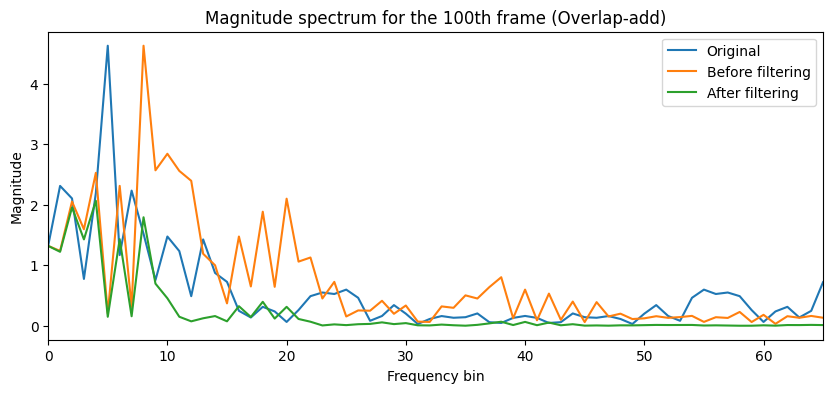

In [20]:
Y0 = abs(fft(waveform[99*80:100*80]))
Y1 = abs(before_filtering1)
Y2 = abs(after_filtering1)
plt.figure(figsize=(10,4))
plt.plot(Y0, label = 'Original')
plt.plot(Y1, label = 'Before filtering')
plt.plot(Y2, label = 'After filtering')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame (Overlap-add)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

### overlap-save
[DFT LPF IDFT of a speech signal using overlap add and
overlap save method]
- Read the input .wav file.
- The LPF is simply moving average filter, i.e., ℎ[𝑛]=1,0≤𝑛≤10 (𝑃=11)

2) For overlap save method,
- Frame shift is 80 samples. (𝐿−𝑃+1=80→𝐿=90)
- For every 80 samples, take 128 point FFT for 90 samples of input. (𝑁=128)
- Multiply it with the FFT of the filter.
- Compute 128 point IFFT and reconstruct the time domain signal.

- Plot of the magnitude spectrum for the 100th frame with that of the input signal before filtering for each method.
- Compare the outputs of the overlap add and overlap save methods.

In [6]:
import torchaudio
import torch
import numpy as np
import matplotlib.pyplot as plt

# 입력 .wav 파일 읽기
file_path = 'input.wav'
waveform, sample_rate = torchaudio.load(file_path)
waveform = waveform[0]  # 스테레오인 경우 첫 번째 채널만 사용

# 이동 평균 필터 정의
P = 11
h = torch.ones(P) / P

# 필터의 FFT 계산 (길이를 128로 제로 패딩)
N = 128
H = torch.fft.fft(h, n=N)

# 오버랩-세이브 방법 파라미터
L = 90
frame_shift = 80
num_frames = (len(waveform) - L + frame_shift) // frame_shift

# 출력 신호를 위한 버퍼
output = torch.zeros(len(waveform))

for i in range(num_frames):
    start_idx = i * frame_shift
    end_idx = start_idx + L
    
    if end_idx > len(waveform):
        break
    
    # 프레임 추출 및 길이를 128로 제로 패딩
    frame = waveform[start_idx:end_idx]
    frame_padded = torch.cat([frame, torch.zeros(N - L)])
    
    # 프레임의 FFT 계산
    X = torch.fft.fft(frame_padded, n=N)
    
    # 필터의 FFT와 곱셈
    Y = X * H
    
    # IFFT를 사용하여 필터링된 프레임 얻기
    y_padded = torch.fft.ifft(Y, n=N).real
    
    # 오버랩-세이브: 필터링된 프레임의 유효 부분을 출력에 추가
    output[start_idx:start_idx + frame_shift] += y_padded[P-1:L]

    # 100번째 프레임의 스펙트럼을 계산
    if i == 99:
        input_spectrum = X
        filtered_spectrum = Y

# 출력 웨이브폼 저장
torchaudio.save('output.wav', output.unsqueeze(0), sample_rate)


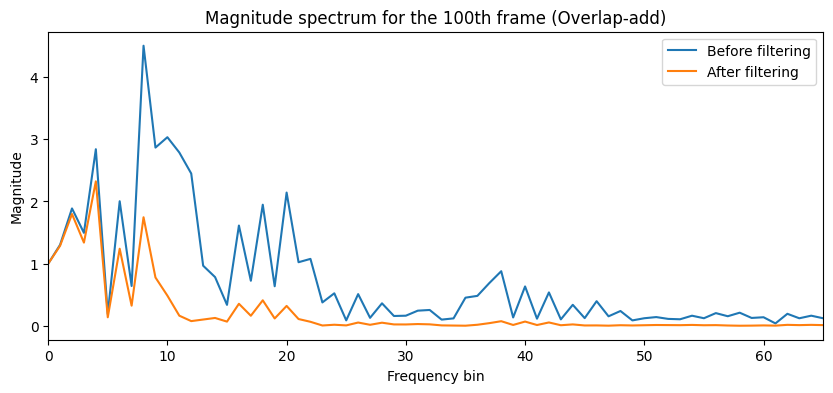

In [7]:
Y3 = abs(input_spectrum)
Y4 = abs(filtered_spectrum)
plt.figure(figsize=(10,4))
plt.plot(Y3, label = 'Before filtering')
plt.plot(Y4, label = 'After filtering')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame (Overlap-add)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

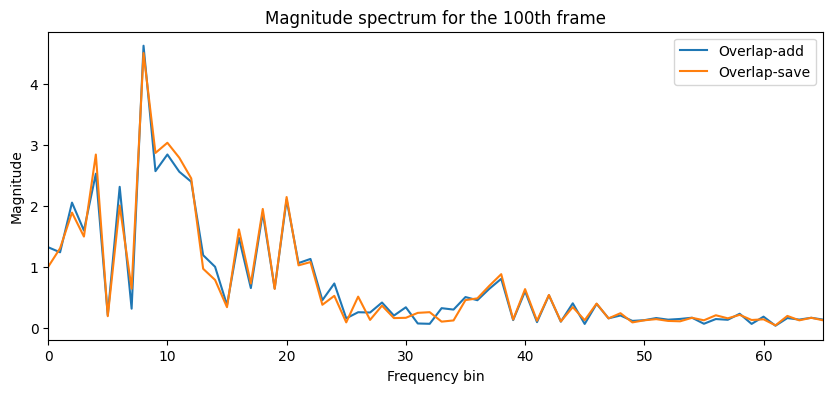

In [8]:
plt.figure(figsize=(10,4))
plt.plot(Y1, label = 'Overlap-add')
plt.plot(Y3, label = 'Overlap-save')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

### overlap-add method with windowing

In [101]:
import torch
import torchaudio
import torch.nn.functional as F
import numpy as np

# Load the input .wav file
waveform, sample_rate = torchaudio.load('input.wav')
waveform = waveform[0]  

# LPF filter coefficients (moving average filter)
LPF = torch.ones(11) / 11.0

# Parameters
L = 80           # Frame shift
N = 128          # Analysis window length
overlap = N - L  # Overlap length, 48
window_length = 128
window_overlap = 24
window = torch.hann_window(window_length, periodic=True)

# Padding zeros to the waveform for handling the last frame
padding = torch.zeros(N - overlap)
waveform = torch.cat((waveform, padding))

# Initialize output signal
output_signal = torch.zeros_like(waveform)

# Process each frame using overlap-add method
for i in range(0, waveform.size(0) - N, L):
    frame = waveform[i:i + N]
    hann_window = torch.cat((window[window_overlap:], torch.ones(N - window_length), window[:window_overlap]))
    windowed_frame = frame * hann_window
    frame_fft = torch.fft.fft(windowed_frame)
    
    if i == 99 * L:
        ms = torch.abs(frame_fft)

    lpf_fft = torch.fft.fft(LPF.to(frame.device), N)
    filtered_frame_fft = frame_fft * lpf_fft
    filtered_frame = torch.real(torch.fft.ifft(filtered_frame_fft))
    output_signal[i:i + N] += filtered_frame

# Remove padding from output signal
output_signal = output_signal[:len(output_signal) - (N - overlap)]
# Save the output as .wav file
torchaudio.save('output3.wav', output_signal.unsqueeze(0), sample_rate)

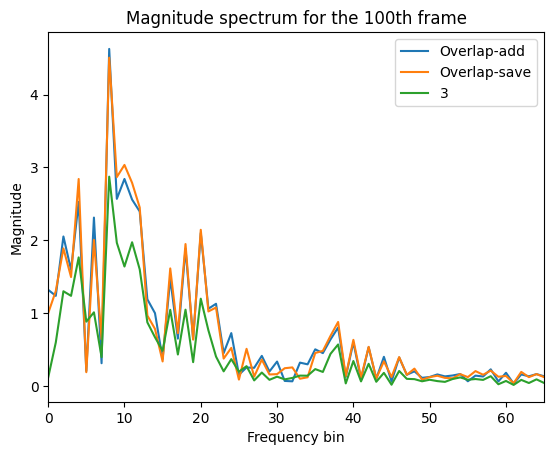

In [99]:
plt.figure()
plt.plot(Y1, label = 'Overlap-add')
plt.plot(Y3, label = 'Overlap-save')
plt.plot(ms, label = '3')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()